# Projected correlation functions with CosmoSIS

The basic CosmoSIS pipeline in this repository will produce projected correlation functions for galaxy clustering $w_{gg}$, the galaxy density-intrinsic shear correlation $w_{g+}$, and the intrinsic shear auto-correlation $w_{++}$.

Models must be chosen for the computation of desired power spectra $P(k)$; here, we use halofit for the non-linear matter power, and we use the Non-Linear Alignment (NLA) model for the matter-intrinsic power $P_{\delta{}I}(k)$ and intrinsic auto-power $P_{II}(k)$.

Alternative choices might include models for baryonic contributions to the matter power, or more complex intrinsic alignment models, e.g. the TATT model, for a perturbative expansion of alignment contributions.

As was discussed during the ECHOIA meeting, whilst CosmoSIS implements no specific Hankel routine for the transformation of $P(k,z)$'s into $w(r_p,z)$'s, we are able to abuse the Hankel transformers implemented for the computation of angular correlation functions from $C_\ell$'s. After running into SegFaults with nicaea, I have switched to another CosmoSIS default module: cl_to_corr.

The pipeline "Cosmosis_wgplus.ini" fully specifies the workflow, and contains comments describing the procedure - I recommend reading these before proceeding.

Let's generate a basic Smail-type redshift distribution $n(z)$ to demonstrate the pipeline:

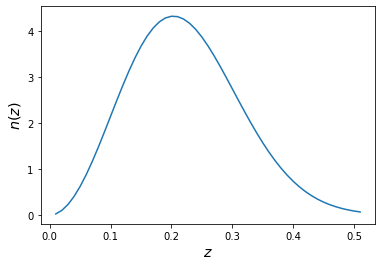

In [71]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# these choices will produce something vaguely GAMA-like
alpha = 2.
beta = 2.2
z0 = 0.3 / np.sqrt(2.)
z = np.linspace(0.01, 0.51, 51)
nz = z**alpha * np.exp(-(z/z0)**beta)
# normalise
nz /= np.trapz(nz, x=z)
# visualise
plt.plot(z, nz)
plt.xlabel('$z$', fontsize='x-large')
plt.ylabel('$n(z)$', fontsize='x-large')
# save as nofz.txt - to be read in by the pipeline
np.savetxt('nofz.txt', np.column_stack((z, nz)), header='z\tbin_1')

We will use this $n(z)$ to describe all of our samples here, but a real analysis will likely employ several such distributions, each describing a sample of galaxies selected on quantities such as colour, magnitude, mass, etc. In those cases, labels for each sample ("nz_test" in this pipeline) must be carefully tracked, and some of the modules written for this notebook will need generalising. For now, let us run this simplified pipeline (can also be done from command line with "cosmosis Cosmosis_wgplus.ini"):

In [72]:
from cosmosis.runtime.config import Inifile
from cosmosis.runtime.pipeline import LikelihoodPipeline
from cosmosis.samplers.test.test_sampler import TestSampler
from cosmosis.output.in_memory_output import InMemoryOutput
ini = Inifile("CosmoSIS_wgplus.ini")
pipeline = LikelihoodPipeline(ini)
sampler = TestSampler(ini, pipeline, None)
sampler.config()
sampler.execute()

-- Setting up module consistency --

-- Setting up module camb --
 camb mode  =            1
 camb cmb_lmax =         2500
 camb FeedbackLevel =            2
 accuracy boost =    1.0000000000000000     
 HighAccuracyDefault =  F

-- Setting up module halofit --

-- Setting up module nonlinear_linear_alignment --

-- Setting up module ia_z_powerlaw --

-- Setting up module constant_bias --

-- Setting up module load_nz --
Found 1 samples and 51 bins in redshift in file /Users/Harry/2ptPipeline/ECHOIA//nofz.txt

-- Setting up module coerce_gg --

-- Setting up module coerce_gI --

-- Setting up module coerce_II --

-- Setting up module project_gg --

-- Setting up module project_gI --

-- Setting up module project_II --

-- Setting up module collect_wgg --

-- Setting up module collect_wgp --

-- Setting up module collect_wpp --

Setup all pipeline modules
Module timing:
consistency 0.001790
camb 0.002403
halofit 0.001565
nonlinear_linear_alignment 0.001556
ia_z_powerlaw 0.001554
constan

/Users/Harry/2ptPipeline/ECHOIA/projected_alignments.py:34: RuntimeWarning: invalid value encountered in true_divide
  Wz_nom = np.nan_to_num((pz_1 * pz_2) / (Xz2 * Xprime))


Should now have a subdirectory called 'datablock', which contains power spectra, distances, parameter values, redshift distributions, and derived quantities, such as our projected correlation functions.

In [73]:
import os
ls = os.listdir('datablock')
ls.sort()
print(ls)

['cmb_cl', 'cosmological_parameters', 'distances', 'galaxy_bias', 'galaxy_intrinsic_power', 'galaxy_power', 'intrinsic_alignment_parameters', 'intrinsic_power', 'linear_cdm_transfer', 'matter_galaxy_power', 'matter_intrinsic_power', 'matter_power_lin', 'matter_power_nl', 'nz_test', 'projected_galaxy_intrinsic', 'projected_galaxy_power', 'projected_intrinsic']


Now let's take a look at the theoretical curves, and compare them to KiDS+GAMA measurements of projected statistics (presented in Johnston et al., 2019). Note that we are using a toy $n(z)$, and ignoring the integral constraint for galaxy clustering, so we do not expect a perfect reproduction. Since we ran with unit galaxy bias $b_g$ and NLA amplitude $A_{IA}$ (see values.ini file) we will re-scale the theory spectra by the best fit parameters from Johnston et al. (2019), who fitted to scales $r_p>6\;{\rm{Mpc}}/h$.

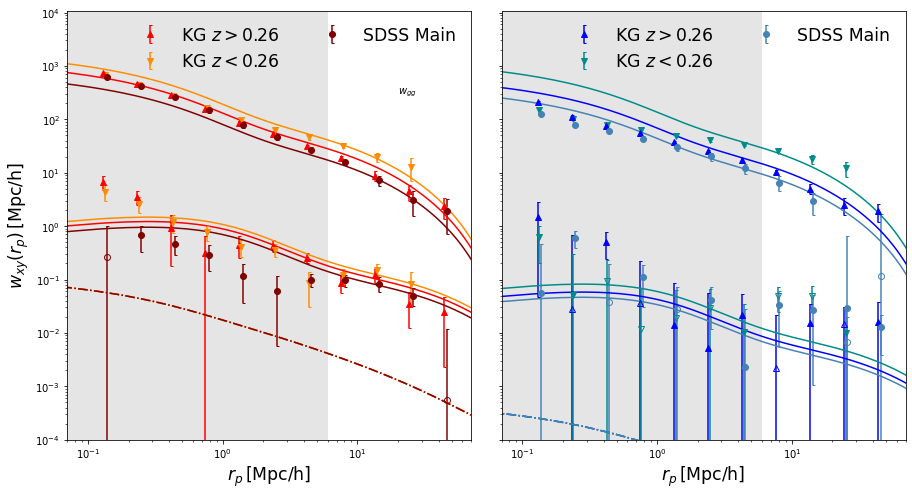

In [75]:
from os.path import join
f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(13, 7))
plt.yscale('log')
plt.xscale('log')
rp = np.loadtxt('datablock/projected_galaxy_intrinsic/theta.txt')
wgg = np.loadtxt('datablock/projected_galaxy_power/wgg_r_1_1.txt')
wgp = np.loadtxt('datablock/projected_galaxy_intrinsic/wgp_r_1_1.txt')
wpp = np.loadtxt('datablock/projected_intrinsic/wpp_r_1_1.txt')
# wg+ is negative by GGL convention, but we tend to measure radial alignments as positive
wgp = -wgp
# mark the non-linear regime where Johnston et al., 2019 did not fit their models
for a in ax:
    a.axvspan(1e-2, 6., color='grey', alpha=0.2, lw=0)

# let's plot the measured data-points for KiDS+GAMA & SDSS Main samples,
# split by redshift and/or galaxy colour. First define some 
# colours/labels/horizontal offsets, for clarity
keys  =                ['z2_b','z2_r','z1_b','z1_r','sdss_b','sdss_r']
names = dict(zip(keys, ['KG $z>0.26$','KG $z>0.26$','KG $z<0.26$','KG $z<0.26$','SDSS Main','SDSS Main']))
cols  = dict(zip(keys, ['blue','red','darkcyan','darkorange','steelblue','maroon']))
marks = dict(zip(keys, ['^','^','v','v','o','o']))
split = dict(zip(keys, [0.97,0.97,1.,1.,1.03,1.03]))
bias  = dict(zip(keys, [1.10,1.52,1.55,1.84,0.88,1.19]))
aia   = dict(zip(keys, [0.21,3.18,0.21,3.18,0.21,3.18]))

for df in os.listdir('J19_measurements'):
    _r, _w, _e = np.loadtxt(join('J19_measurements', df)).T
    name = df.replace('wgp_','').replace('wgg_','')
    if name.endswith('_r'):   a = ax[0]
    elif name.endswith('_b'): a = ax[1]

    # scale theory correlation functions & determine labels
    if 'wgg' in df:
        th_w = wgg * bias[name]**2.
        label = None
    elif 'wgp' in df:
        th_w = wgp * aia[name] * bias[name]
        th_wpp = wpp * aia[name]**2.
        label = names[name]
        
    # discard largest-r_p bin for low-z GAMA (see Johnston et al., 2019)
    if 'z1' in df:
        _r, _w, _e = map(lambda x: x[:-1], (_r, _w, _e))

    # plot measurements, with open points for negative values
    c = _w > 0.
    eb = a.errorbar(_r[c]*split[name], _w[c], _e[c],
                      ls='', marker=marks[name], c=cols[name],
                      label=label, capsize=1.5)
    if any(_w < 0.):
        a.errorbar(_r[~c]*split[name], -_w[~c], _e[~c],
                      ls='', marker=marks[name], c=cols[name],
                      label=None, capsize=1.5, mfc='none')

    # plot theory curves
    a.plot(rp, th_w, c=eb[0].get_c())
    # also plot expected w++ for completeness, though low S/N
    # means that we have no measurements to compare with
    if 'wgp' in df:
        a.plot(rp, th_wpp, c=eb[0].get_c(), ls='-.')

for a in ax:
    a.legend(loc='best', ncol=2, frameon=0, fontsize='xx-large')
    a.set_xlabel('$r_p\,[\\rm{Mpc/h}]$', fontsize='xx-large')
ax[0].set_ylabel('$w_{xy}(r_p)\,[\\rm{Mpc/h}]$', fontsize='xx-large')
ax[0].annotate('$w_{gg}$', xy=(20,300), xycoords='data', f)
plt.xlim(0.07, 70)
plt.ylim(1e-4, None)
plt.tight_layout()

As you can see, the theoretical curves produced here are very close to the published, no-shortcuts versions. I can be reached at h.s.johnston@uu.nl for any questions regarding the example CosmoSIS pipeline, or for suggestions to improve this notebook. When I find the time, I cam include a routine to produce the same quantities using CCL.